<a target="_blank" href="https://colab.research.google.com/github/lm2612/Tutorials/blob/main/3_deeplearning/3-DeepLearning_HousePrice.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep learning: House price prediction

On Tuesday, we used linear regression to predict house prices of the [California house price dataset](https://www.kaggle.com/camnugent/california-housing-prices). Our dataset contains 200 observations for housing blocks in California obtained from the 1990 census. The dataset contains columns:

1. `longitude`: A measure of how far west a house is; a higher value is farther west

2. `latitude`: A measure of how far north a house is; a higher value is farther north

3. `housing_median_age`: Median age of a house within a block; a lower number is a newer building

4. `total_rooms`: Total number of rooms within a block

5. `total_bedrooms`: Total number of bedrooms within a block

6. `population`: Total number of people residing within a block

7. `households`: Total number of households, a group of people residing within a home unit, for a block

8. `median_income`: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

9. `median_house_value`: Median house value for households within a block (measured in US Dollars)

10. `ocean_proximity`: Location of the house w.r.t ocean/sea

Previously, we used intuition to guess what input variables would be suitable predictors. In this example, we are going to  use all the variables available and to predict `median_house_value`.

You must be on google colab for this tutorial - otherwise you will not be able to open the dataset. First, import the needed modules, we will be using `torch` for building neural networks. On Tuesday we used a smaller subset of the full dataset. Load the file `sample_data/california_housing_train.csv`.

In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)

df = pd.read_csv("sample_data/california_housing_train.csv")
print(len(df))
df.head()

17000


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


Notice the dataset is much larger than Tuesday! Clean up the data and split it into training and validation. Note, we don't need to set aside test data as we will use the test data in `sample_data/california_housing_test.csv`. Remember the data is ordered, you may want to shuffle it.

In [3]:
# Shuffle the DataFrame
df = df.sample(frac=1, random_state=0).reset_index(drop=True)

# Split the data into training and validation sets (80/20 split)
train_size = int(0.8 * len(df))
train_df = df[:train_size]
val_df = df[train_size:]

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

Training set size: 13600
Validation set size: 3400


In [ ]:
# # Remove nans
# df =

# # Shuffle the data
# from sklearn.utils import shuffle
# df =

In [ ]:
# # Use 80% training, 20% validation
# training = df.iloc[
# validation = df.iloc[

Get your X and y variables. We will use all of the predictors for X and scale them to zero mean unit variance.

In [5]:
y = train_df["median_house_value"].values.reshape(-1, 1)
X = train_df[['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']].values
X.shape, y.shape

((13600, 8), (13600, 1))

In [6]:
from sklearn.preprocessing import StandardScaler

# Use StandardScaler to fit and transform your variables
# Create a StandardScaler instance for features (X)
scaler_X = StandardScaler()

# Fit the scaler to the training data and transform X
X_scaled = scaler_X.fit_transform(X)

# Create a StandardScaler instance for the target variable (y)
scaler_y = StandardScaler()

# Fit the scaler to the training data and transform y
y_scaled = scaler_y.fit_transform(y)

'''
1. Feature Scale Differences and Algorithm Performance:

Many machine learning algorithms are sensitive to the scale of features. If features have vastly different ranges (e.g., one feature ranges from 0 to 1, while another ranges from 1000 to 10000), those with larger ranges can disproportionately influence the model's learning process.
Algorithms like gradient descent, k-nearest neighbors, support vector machines, and linear regression can be significantly affected by unscaled data.
For example, in distance-based algorithms like k-nearest neighbors, features with larger ranges will have a greater impact on the distance calculations, potentially leading to biased results.
2. Improved Model Performance:

Scaling helps to level the playing field for all features, allowing the model to learn relationships between them more effectively. This often leads to improved model accuracy and performance.
By reducing the dominance of features with larger ranges, scaling helps prevent the model from being overly influenced by irrelevant or less important features.
3. Faster Convergence:

Scaling can significantly speed up the training process, particularly for algorithms like gradient descent. When features are on different scales, the optimization process can take longer to converge to a solution. Scaling helps to normalize the feature space, enabling the algorithm to find the optimal solution more efficiently.
4. Comparability:

Scaling makes it easier to compare and interpret the importance of different features. When features are on the same scale, their coefficients or feature importance scores become more meaningful and comparable.
5. Algorithm Requirements:

Some algorithms, like principal component analysis (PCA) and support vector machines (SVM), may require or benefit significantly from data scaling as part of their inherent workings.
In summary:

Scaling your data is generally a good practice in machine learning, especially when using algorithms that are sensitive to feature scales. It helps to improve model performance, speed up training, and make the results more interpretable. While there might be exceptions where scaling is not strictly necessary, it's often a safe and beneficial step to include in your preprocessing pipeline.
'''

Create torch tensors ready for the neural network.

In [7]:
X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y_scaled, dtype=torch.float32)

## Build a neural network

Create a simple neural network. It can include as many or as few layers as you like. We will start simple with a 3-layer dense neural network, where we have an input layer, and 2 hidden layers with 16 nodes. For the input layer, we need to tell pytorch the number of input features (9). Then we can choose the number of hidden nodes.

In [8]:
class SimpleNet(torch.nn.Module):
    def __init__(self, n_features=8, n_targets=1):
        super().__init__()
        self.n_features = n_features
        self.n_targets = n_targets

        self.layer_input = torch.nn.Linear(self.n_features, 16)         # Input layer: n_features -> 16
        self.layer_hidden1 = torch.nn.Linear(16, 16)                    # Hidden layer 1: 16 -> 16
        self.layer_hidden2 = torch.nn.Linear(16, self.n_targets)        # Hidden layer 2: 16 -> n_targets

        self.activation_function = torch.nn.ReLU()

    def forward(self, X):
        # Input layer
        output = self.layer_input(X)
        output = self.activation_function(output)

        # Hidden layer 1
        output = self.layer_hidden1(output)
        output = self.activation_function(output)

        # Hidden layer 2
        output = self.layer_hidden2(output)
        # Notice we don't use the activation function here - why not? when would we use it?

        return output

## Check our network on one batch
Let's test our neural network on a small batch of data, before we start our training loop. Create an instance of SimpleNet and test it on a batch size of 64.

In [9]:
# Create an instance of SimpleNet
my_network = SimpleNet(n_features=8, n_targets=1)
batch_size = 64

# Get a batch of data
X_batch = X[:batch_size]
y_batch = y[:batch_size]

# Test if we can call my_network without any errors
pred_batch = my_network(X_batch)

# Check the output is the correct size
print(pred_batch.shape)
assert(pred_batch.shape == y_batch.shape)

torch.Size([64, 1])


## Set up loss function and optimisation algorithms

Decide on a suitable loss function.

We will use Mean Squared Error (MSE). It is always good to check you can properly call this on your first batch of data.

In [10]:
loss_function = torch.nn.MSELoss()
loss_function(pred_batch, y_batch)

tensor(0.9050, grad_fn=<MseLossBackward0>)

Set up the optimiser and pass our network parameters to it. We will use the Adam optimiser.

In [11]:
optimiser = torch.optim.Adam(params = my_network.parameters(), lr=0.01)

'''
This line is crucial for training our neural network. It sets up the optimization process that will help the network learn and improve its predictions. Here's a step-by-step explanation:

optimiser =: This part is simply creating a variable named optimiser to store our chosen optimization algorithm. Think of it as a container for the optimization process.

torch.optim.Adam: This is the specific optimization algorithm we're using, called "Adam." It's a popular choice for training neural networks because it's generally efficient and effective.

params = my_network.parameters(): This is where we tell the optimizer which values it should adjust during training. my_network.parameters() refers to all the adjustable parameters (weights and biases) within our neural network, my_network. These are the internal values that the optimizer will try to tweak to improve the network's performance.

lr=0.01: "lr" stands for "learning rate." It's a crucial parameter that controls how much the optimizer adjusts the network's parameters in each step of training. A learning rate of 0.01 means that the optimizer will make relatively small adjustments to the parameters during each update. Finding a good learning rate is often important for successful training.
'''

## Training loop
We are ready to start our training loop. We could manually iterate through the data using indices, e.g., `X[0:64, :], y[0:64, :], ...`. But pytorch simplifies this for us with some useful functions, including mini-batching and shuffling - this will become essential when we move to large datasets. This is done in two steps, both of which are highly customisable.
First, we create a `Dataset` which contains all of our data (you can also include any relevant pre-processing functions inside the Dataset). For regression, we provide our inputs and outputs.
Then, we use a `DataLoader` that allows us to iterate through minibatches of data.

In [12]:
dataset = torch.utils.data.TensorDataset(X, y)
dataloader = torch.utils.data.DataLoader(dataset,
                                         shuffle=True,
                                         batch_size=64)

In [13]:
# Check we can iterate through the dataloader
X_batch, y_batch = next(iter(dataloader))
X_batch.shape, y_batch.shape

(torch.Size([64, 8]), torch.Size([64, 1]))

In [14]:
losses = []

for X_batch, y_batch in dataloader:
    optimiser.zero_grad()
    pred_batch = my_network(X_batch)
    loss = loss_function(pred_batch, y_batch)
    loss.backward()

    # Update optimiser
    optimiser.step()

    # Add MSE losses to our list for plotting
    losses.append(loss.item())



Plot the losses for this

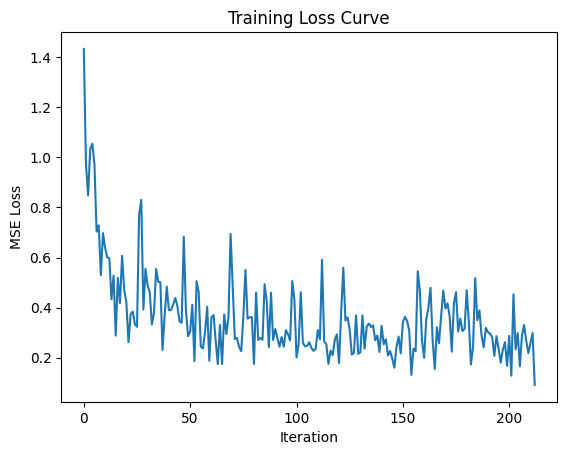

In [15]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.show()

## Check validation dataset
Predict using the validation dataset and compare to the true validation dataset. Check our loss function (MSE).


In [16]:
# prompt: Predict using the validation dataset and compare to the true validation dataset. Check our loss function (MSE). Also include explanation to the code

# Prepare the validation data
y_val = val_df["median_house_value"].values.reshape(-1, 1)
X_val = val_df[['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']].values

# Scale the validation data using the same scalers fitted on the training data
X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.transform(y_val)

# Convert validation data to PyTorch tensors
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)

# Make predictions on the validation set
with torch.no_grad():  # Disable gradient calculation for inference
    val_predictions = my_network(X_val_tensor)

# Calculate the MSE loss on the validation set
val_loss = loss_function(val_predictions, y_val_tensor)
print(f"Validation MSE Loss: {val_loss.item()}")

# Inverse transform the predictions and true values to get them back to the original scale.
val_predictions_original_scale = scaler_y.inverse_transform(val_predictions.numpy())
y_val_original_scale = scaler_y.inverse_transform(y_val_tensor.numpy())


# Now you can compare val_predictions_original_scale with y_val_original_scale in the original scale
# Example: calculate some metrics like R-squared or Mean Absolute Error
# ...

Validation MSE Loss: 0.2884826958179474


In [19]:
# Test the network on the validation dataset! Note, we need to put the network in "evaluation" mode first

# Set the network to evaluation mode
my_network.eval()

# Prepare the validation data (assuming X_val_tensor and y_val_tensor are already defined)
# ... (your code to prepare X_val_tensor and y_val_tensor)

# Make predictions on the validation set
with torch.no_grad():  # Disable gradient calculation for inference
    val_predictions = my_network(X_val_tensor)

# Calculate the MSE loss on the validation set
val_loss = loss_function(val_predictions, y_val_tensor)
print(f"Validation MSE Loss: {val_loss.item()}")

# Inverse transform the predictions and true values to get them back to the original scale.
val_predictions_original_scale = scaler_y.inverse_transform(val_predictions.numpy())
y_val_original_scale = scaler_y.inverse_transform(y_val_tensor.numpy())

# Now you can compare val_predictions_original_scale with y_val_original_scale in the original scale
# Example: calculate some metrics like R-squared or Mean Absolute Error
# ...

Validation MSE Loss: 0.2884826958179474


In [ ]:
# Test the network on the validation dataset! Note, we need to put the network in "evaluation" mode first
my_network.eval()       # Puts network into evaluation mode
pred_validation =
# Check the loss
loss =
loss

Plot the predicted against the truth

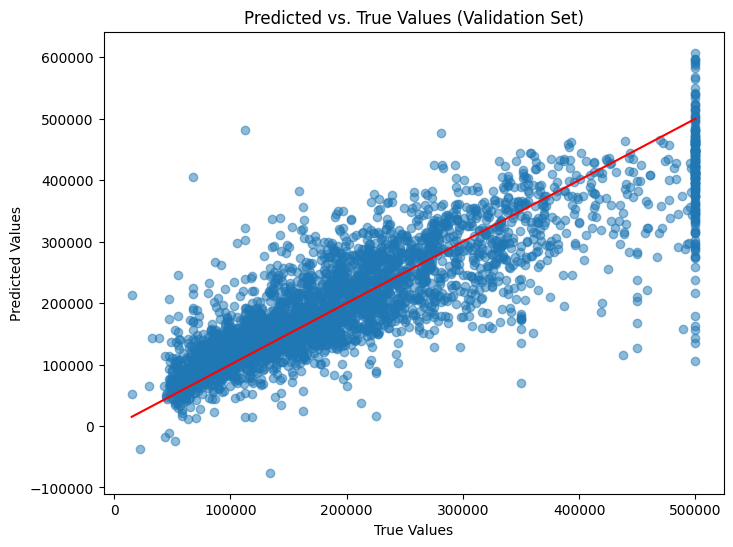

In [18]:
# prompt: Plot the predicted against the truth

plt.figure(figsize=(8, 6))
plt.scatter(y_val_original_scale, val_predictions_original_scale, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. True Values (Validation Set)")
plt.plot([min(y_val_original_scale), max(y_val_original_scale)], [min(y_val_original_scale), max(y_val_original_scale)], color='red') # Add a diagonal line for reference
plt.show()

How does it compare to your linear regression models on Tuesday?



## Train over multiple epochs

Now you have gone through one full iteration of the data, train over multiple epochs and make sure you go through the validation dataset each epoch. Keep track of the training and validation losses averaged over each epoch separately and plot these.

In [ ]:
training_losses = []
validation_losses = []
num_epochs = 100


for epoch in range(num_epochs):
    # Set up training
    my_network.train()
    training_loss = 0

    # TRAINING LOOP
    # This will look the similar our previous single iteration
    for ...

    # Sum the training loss at each iteration and store the mean training loss at the end of the epoch
    training_losses.append(training_loss)

    # Set up validation
    my_network.eval()
    validation_loss = 0

    # VALIDATION LOOP
    # This will look similar to your training loop, but remember you do not need to do the optimise step
    for ...

    # Add MSE losses to our list for plotting
    validation_losses.append(validation_loss)

    # After every 10 epochs print mean losses
    if epoch%10 ==0:
        print(f"After epoch {epoch}: Training loss={training_loss:.2f}, validation loss={validation_loss:.2f}")

print(f"At end of training: Training loss={training_loss:.2f}, validation loss={validation_loss:.2f}")


Check the training and validation loss curves. How do they differ?

## Overfitting
Keep training your network and look for signs of overfitting.

## Bonus: Exploring different choices
Play around with different versions of the network. For example, try:
* More or fewer layers.
* More of fewer hidden nodes.
* Different choice of [activation functions](https://pytorch.org/docs/main/nn.html#non-linear-activations-weighted-sum-nonlinearity)
* Different choice of [loss functions](https://pytorch.org/docs/main/nn.html#loss-functions)
* Different choice of [optimiser](https://pytorch.org/docs/main/optim.html#algorithms)

Selecting these choices for your problem is an optimisation problem in itself. This is often called hyperparameter selection. There is no best approach - usually people would manually search through some different options until we have the best results. Finding quicker methods for "hyperparameter optimisation" is a research field in itself!



### More layers
Add one layer with 32 hidden nodes and see if it you get a better performance on the validation dataset.

## Bonus: Other network parameters
Explore the following options:
* add BatchNorm
* replace the ReLU activation function with the Sigmoid activation function
* remove a hidden layer
* try a different optimisation method

## Testing
Select your best network and apply it to the test data and calculate the RMSE. Don't forget your outputs are scaled.

In [ ]:
# Open test data
testing = pd.read_csv("sample_data/california_housing_test.csv")
testing.head()

## Compare to Linear Regression
Compare your code the linear regression results you got on Tuesday. Note you will need to re-run your linear regression on this new test dataset. You may also want to re-train on this larger training dataset for a fair comparison.
